In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()
import pytorch
from pytorch import dataset as ptd

import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="mnist"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=ptd.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


Using TensorFlow backend.
/home/facundo/.python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


x_train shape: (60000, 28, 28, 1) uint8
x_test shape: (10000, 28, 28, 1) uint8
y_train shape: (60000, 10) float64
y_test shape: (10000, 10) float64
60000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [4]:
from pytorch import training

import pytorch_models

conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64,"fashion_mnist":64,"lsa16":32}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128,"fashion_mnist":128,"lsa16":64}
model = pytorch_models.SimpleConv(input_shape,num_classes,
                                 conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
#model= pytorch_models.FFNet(input_shape,num_classes)x
if use_cuda:
    model=model.cuda()
parameters=training.add_weight_decay(model.named_parameters(),1e-9)
optimizer = optim.Adam(parameters, lr=0.001)
print(model)

rotated_model= pytorch_models.SimpleConv(input_shape,num_classes,
                                       conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
if use_cuda:
    rotated_model= rotated_model.cuda()
rotated_parameters=training.add_weight_decay(rotated_model.named_parameters(),1e-9)
rotated_optimizer = optim.Adam(rotated_parameters, lr=0.001)

print(rotated_model)
#summary(model, input_size=[1,28,28])


SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): SequentialWithIntermediates(
    (0): Linear(in_features=6272, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(

Training model with unrotated dataset...


Epoch 1: 100% (batch 469/469)  ==stats==> loss:  0.177, accuracy:  0.943, Time:  0:00:07


Test => Loss: 0.0384, Accuracy: 98.74% (9874/10000)


Epoch 2: 100% (batch 469/469)  ==stats==> loss: 0.0419, accuracy:  0.987, Time:  0:00:07


Test => Loss: 0.0291, Accuracy: 99.03% (9903/10000)


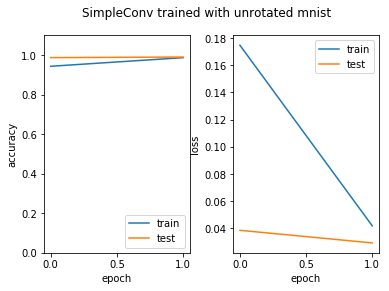

Skipping pretraining rotated model with unrotated dataset
Training rotated model with rotated dataset...


Epoch 1: 100% (batch 469/469)  ==stats==> loss:  0.544, accuracy:  0.819, Time:  0:00:07


Test => Loss: 0.2597, Accuracy: 92.10% (9210/10000)


Epoch 2: 100% (batch 469/469)  ==stats==> loss:  0.196, accuracy:  0.938, Time:  0:00:07


Test => Loss: 0.1620, Accuracy: 94.72% (9472/10000)


Epoch 3: 100% (batch 469/469)  ==stats==> loss:  0.153, accuracy:  0.951, Time:  0:00:07


Test => Loss: 0.1393, Accuracy: 95.60% (9560/10000)


Epoch 4: 100% (batch 469/469)  ==stats==> loss:  0.125, accuracy:  0.961, Time:  0:00:07


Test => Loss: 0.1121, Accuracy: 96.25% (9625/10000)


Epoch 5: 100% (batch 469/469)  ==stats==> loss:  0.113, accuracy:  0.965, Time:  0:00:07


Test => Loss: 0.1174, Accuracy: 96.24% (9624/10000)


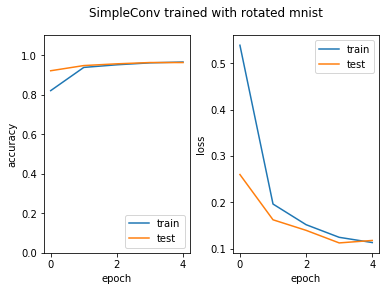

Testing both models on both datasets...


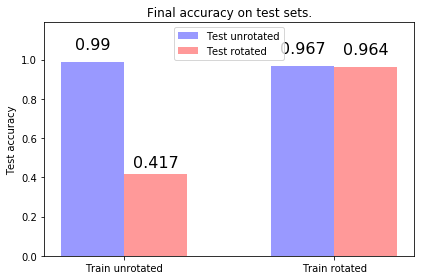

model_rotated_test_dataset score: loss=3.873559, accuracy=0.417000
model_rotated_train_dataset score: loss=3.896501, accuracy=0.415267
model_test_dataset score: loss=0.029146, accuracy=0.990300
model_train_dataset score: loss=0.022217, accuracy=0.993650
rotated_model_rotated_test_dataset score: loss=0.110177, accuracy=0.964200
rotated_model_rotated_train_dataset score: loss=0.108177, accuracy=0.965650
rotated_model_test_dataset score: loss=0.103238, accuracy=0.966900
rotated_model_train_dataset score: loss=0.104144, accuracy=0.967433


In [5]:
batch_size = 128

epochs={'cifar10':5,'mnist':2,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':50,'mnist_rot':5,'pugeault':15}
from pytorch.experiment import rotation
rotated_epochs={'cifar10':100,'mnist':5,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

config=pytorch.experiment.rotation.TrainRotatedConfig(batch_size=batch_size,
                   epochs=epochs[dataset.name],rotated_epochs=rotated_epochs[dataset.name],
                   pre_rotated_epochs=0, optimizer=optimizer,rotated_optimizer=rotated_optimizer,
                  use_cuda=use_cuda)

scores=rotation.run(config,model,rotated_model,dataset,plot_accuracy=True,save_plots=False)
for k,v in scores.items():
    print('%s score: loss=%f, accuracy=%f' % (k,v[0],v[1]))


In [6]:
from pytorch.experiment import invariance
n_rotations=16
rotations=np.linspace(-180,180,n_rotations,endpoint=False)

vmax_class={"lsa16":6,"mnist":5,"cifar10":10}
vmax_all={"lsa16":3.5,"mnist":5,"cifar10":10}

rotated_invariance_measure,rotated_stratified_invariance_measure,classes=invariance.run(rotated_model,dataset,config,rotations)
invariance_measure,stratified_invariance_measure,classes=invariance.run(model,dataset,config,rotations)

vmin_class,vmax_class=invariance.outlier_range_both(rotated_invariance_measure,invariance_measure)
vmin_class=0





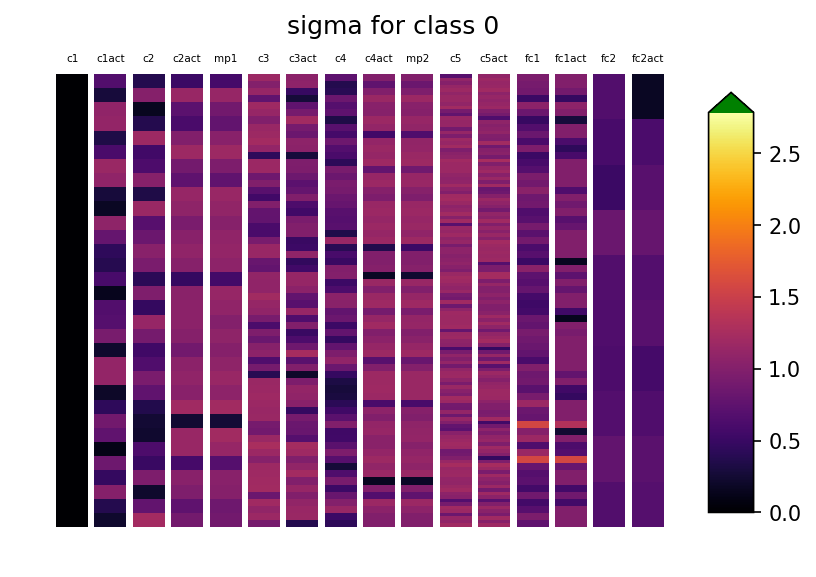

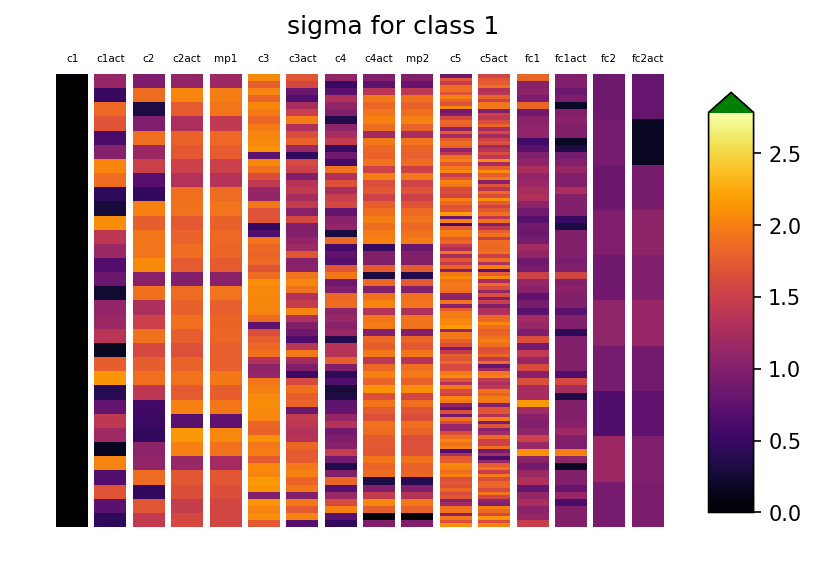

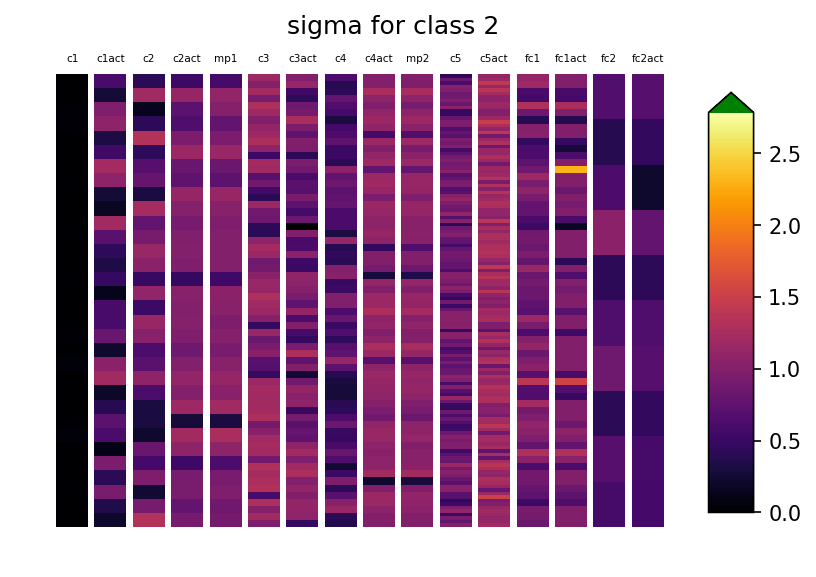

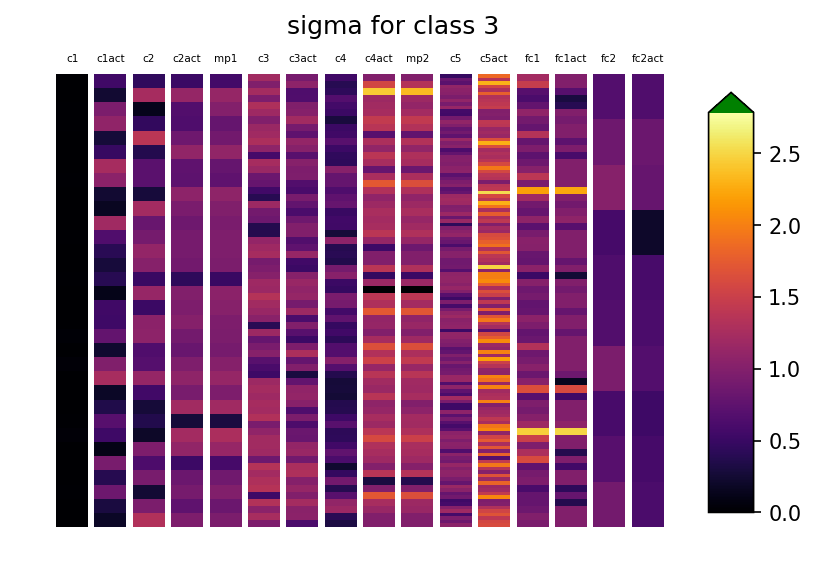

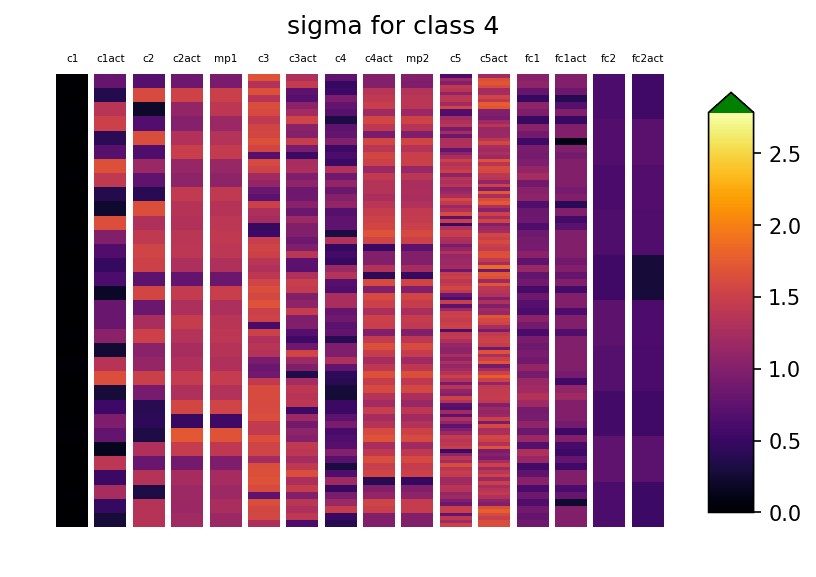

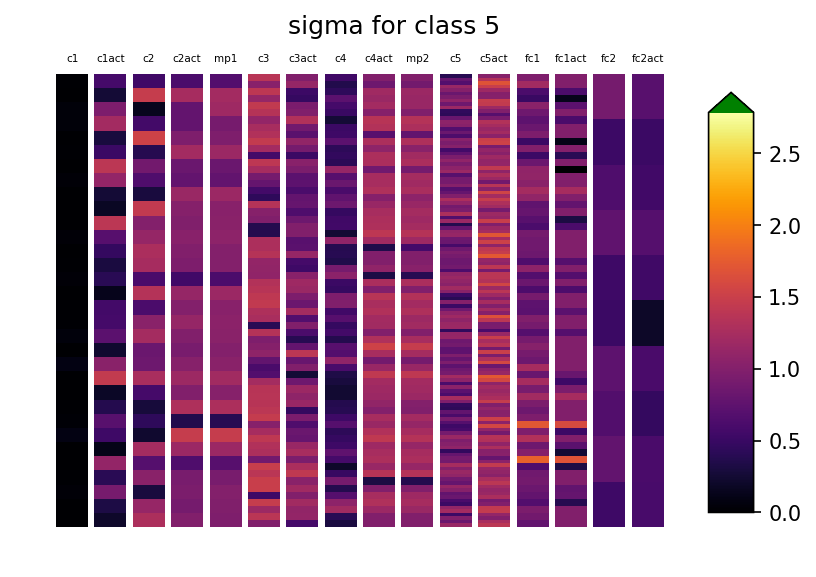

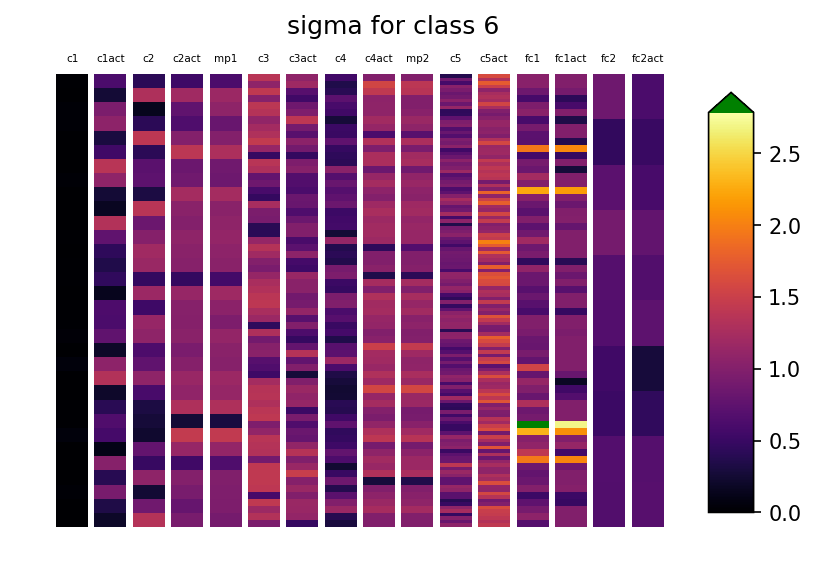

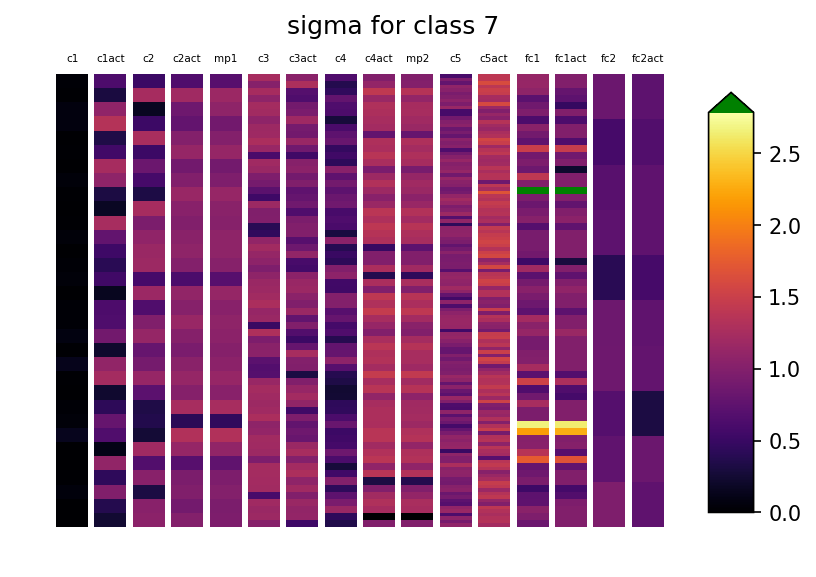

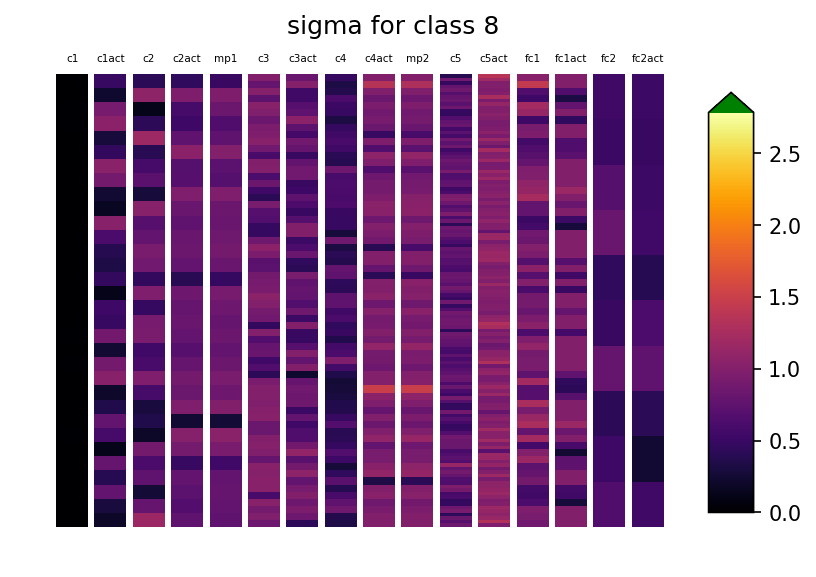

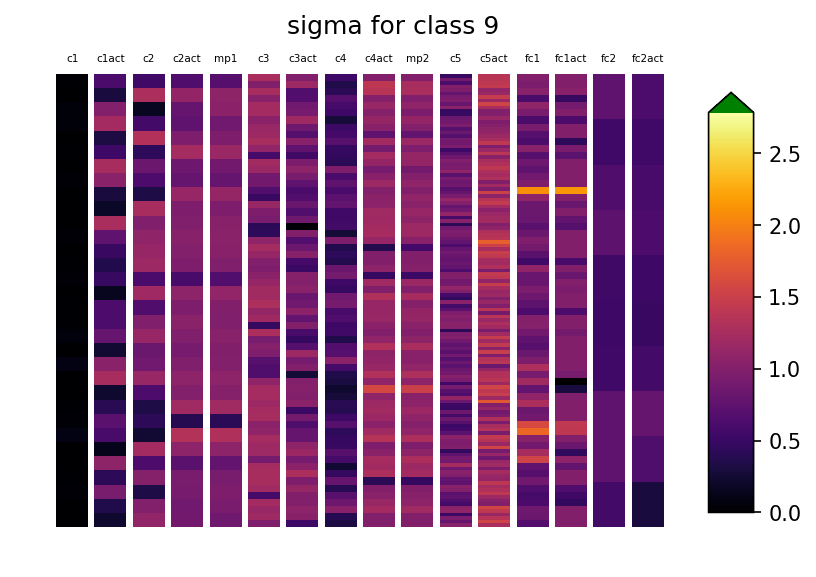

In [7]:


invariance.plot(rotated_invariance_measure,model,dataset.name,classes,savefig=True,savefig_suffix="rotated",vmax=vmax_class)



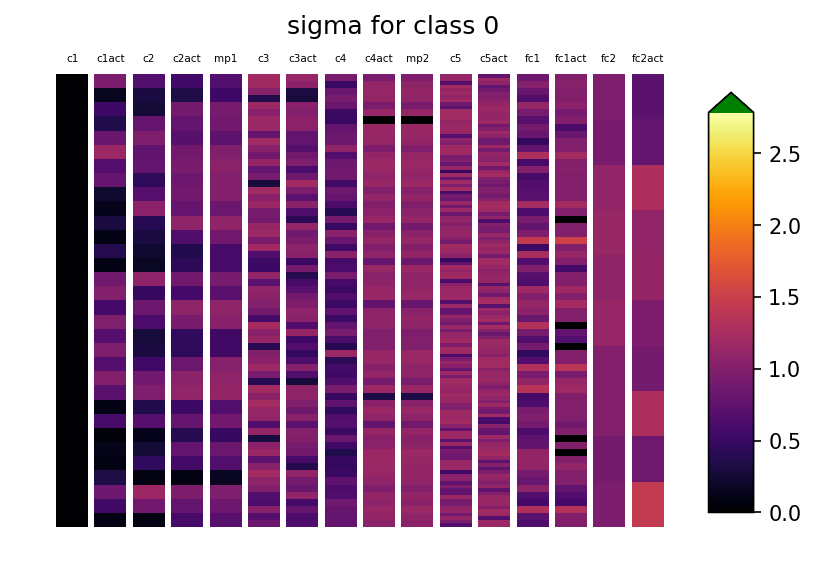

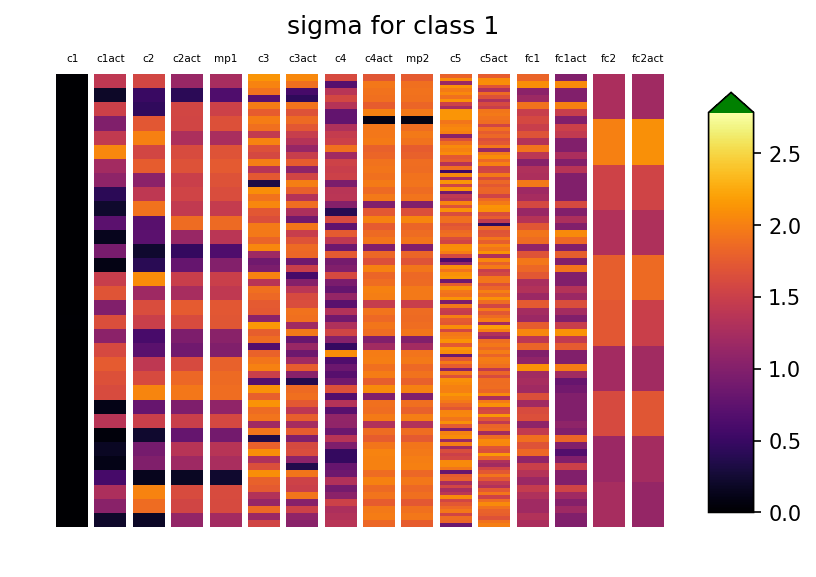

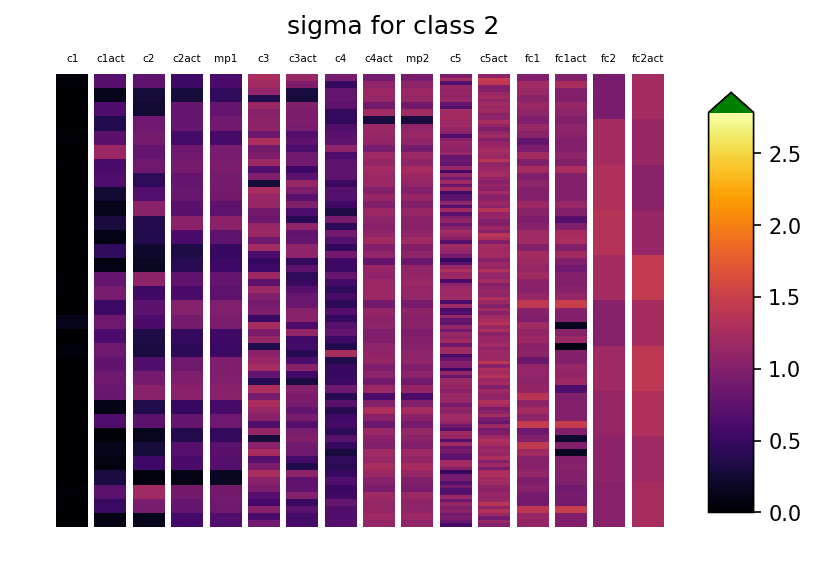

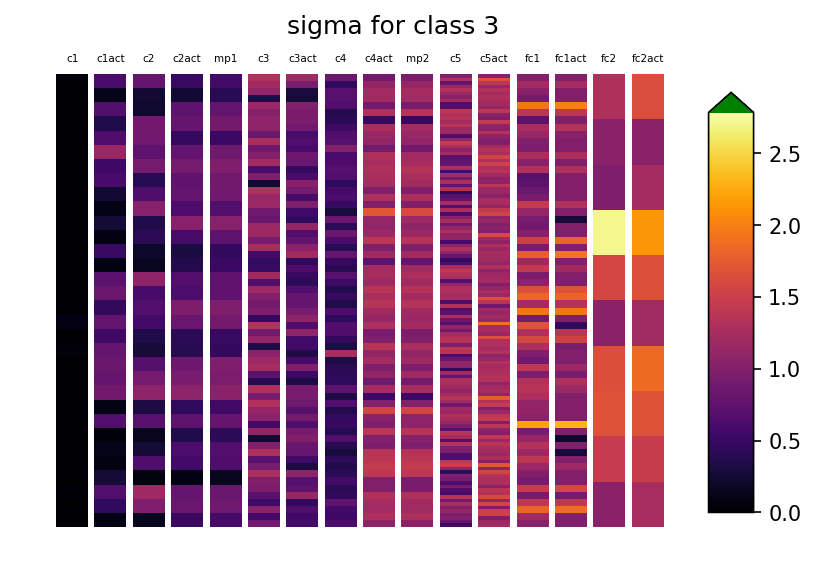

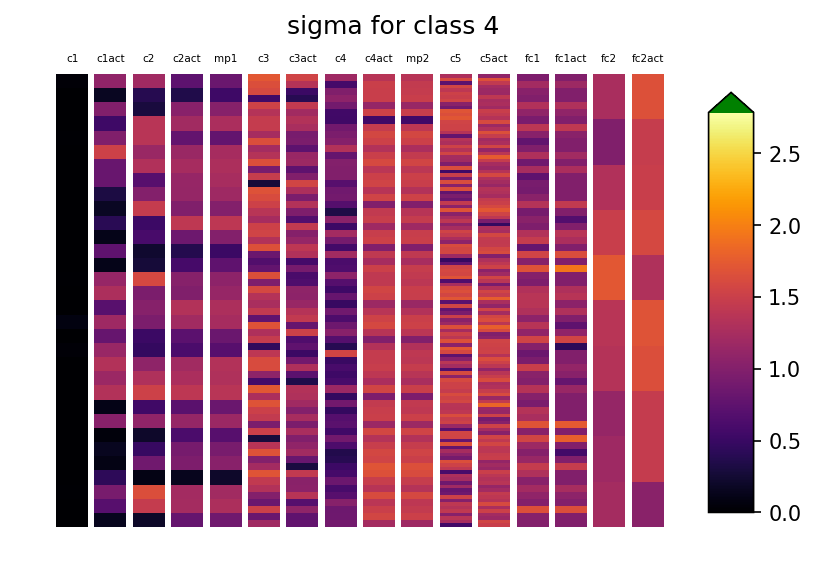

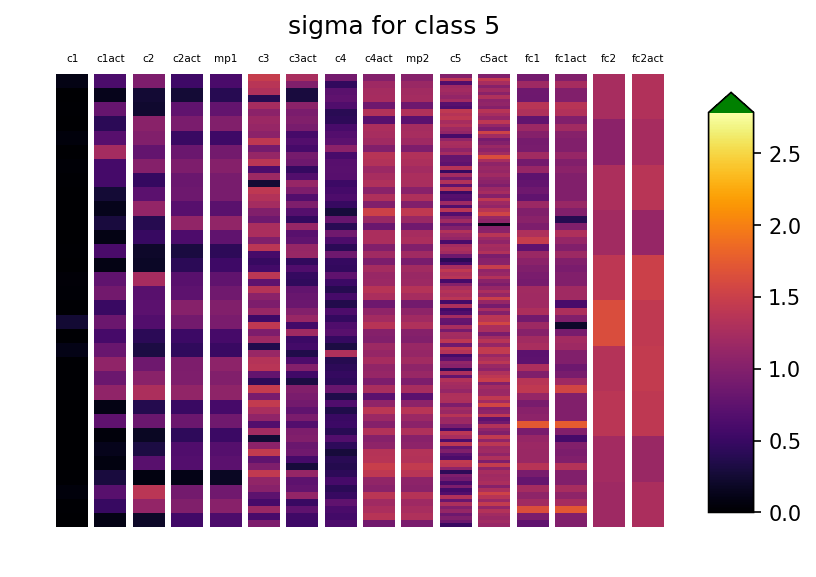

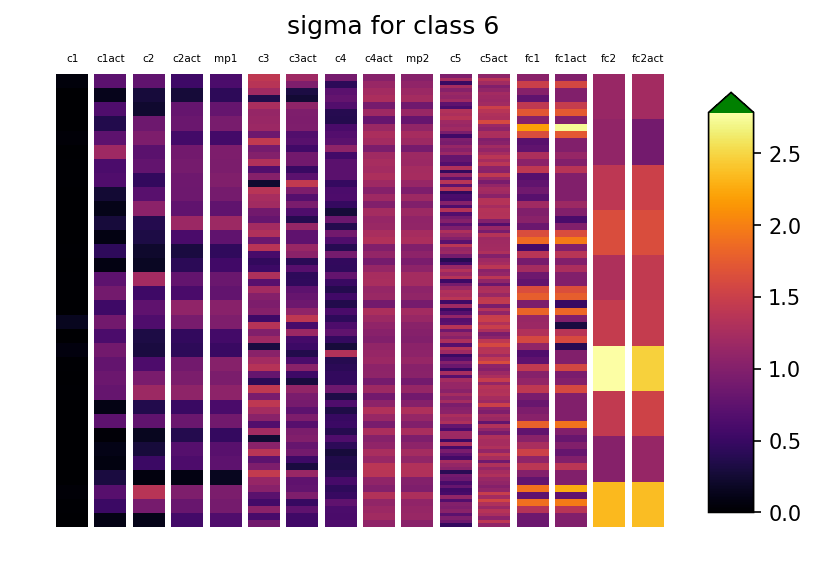

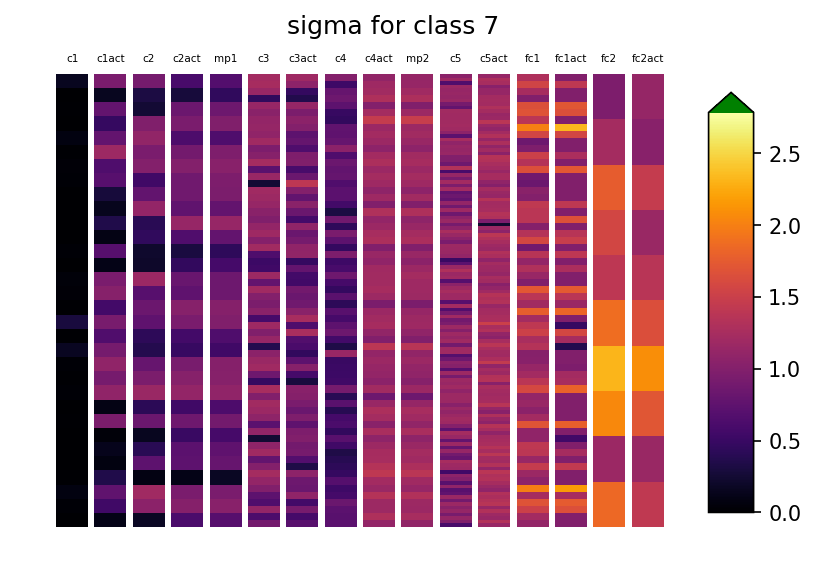

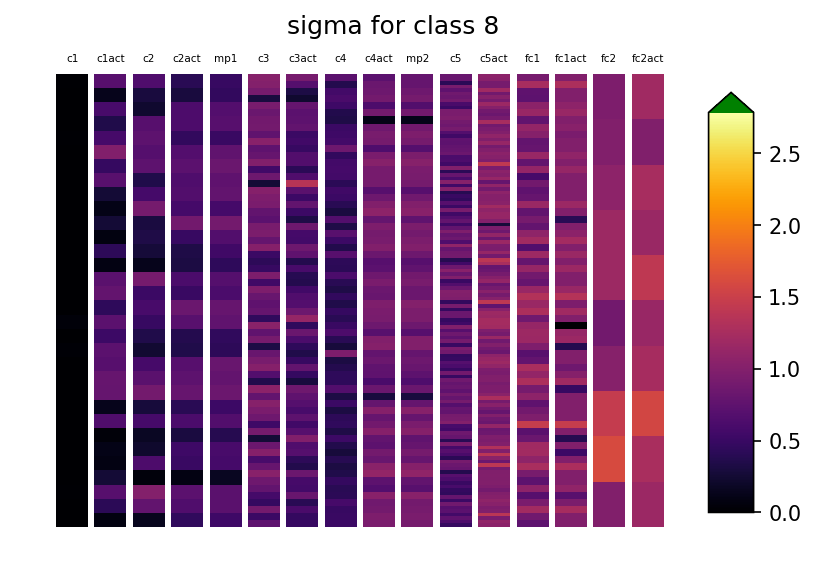

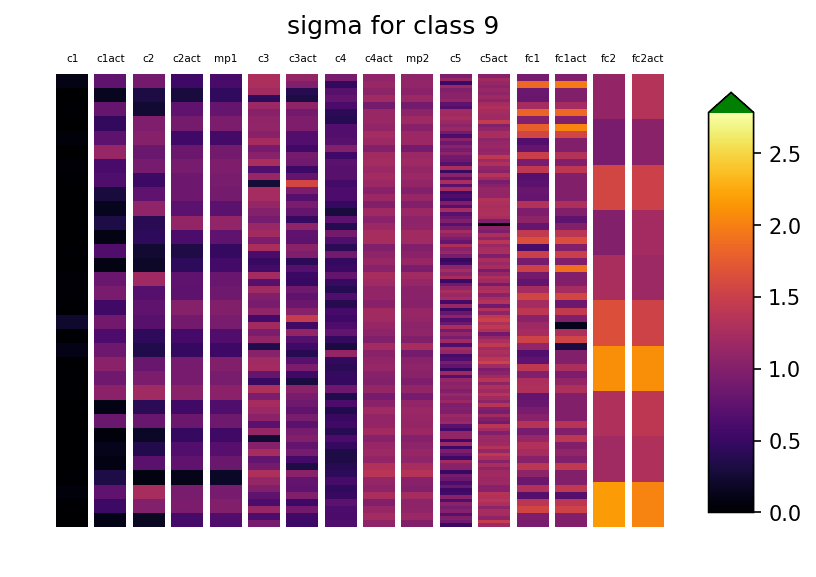

In [8]:

invariance.plot(invariance_measure,model,dataset.name,classes,savefig=True,savefig_suffix="unrotated",vmax=vmax_class)


In [9]:
rotated_invariance_measure_all_dataset,classes=invariance.run_all_dataset(rotated_model,dataset,config,rotations)
invariance_measure_all_dataset,classes=invariance.run_all_dataset(model,dataset,config,rotations)

vmin_all,vmax_all=invariance.outlier_range_both(rotated_invariance_measure,invariance_measure)
vmin_all=0


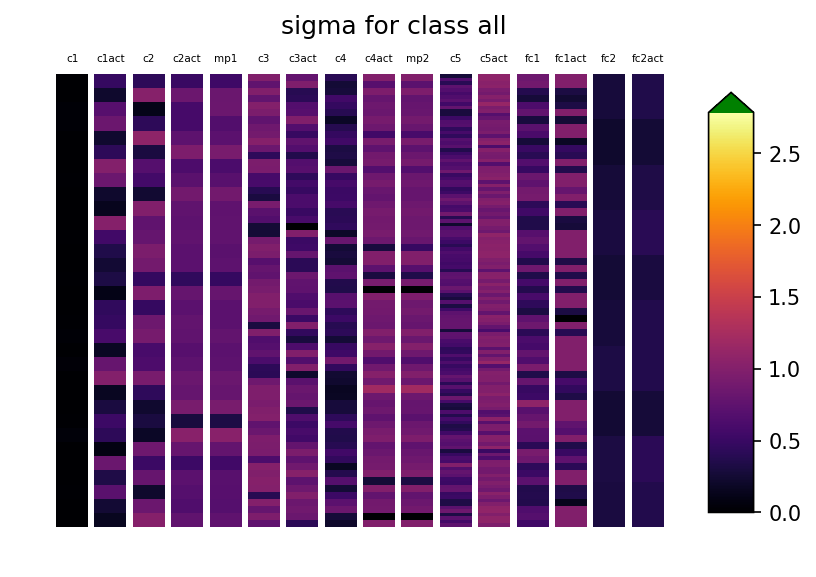

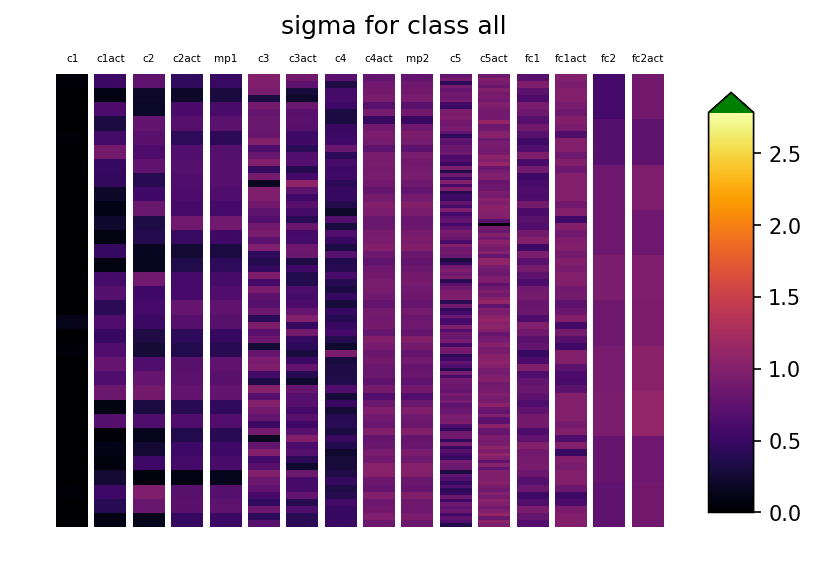

In [11]:
# for i in range(1):
#     print(f"class {i}")
#     print([rotated_invariance_measure_all_dataset[i][j].shape for j in range(20)])
#     print([invariance_measure_all_dataset[i][j].shape for j in range(20)])

invariance.plot(rotated_invariance_measure_all_dataset,rotated_model,dataset.name,classes,
                savefig=True,savefig_suffix="rotated",class_names=["all"],vmax=vmax_all)

invariance.plot(invariance_measure_all_dataset,model,dataset.name,classes,
                savefig=True,savefig_suffix="unrotated",class_names=["all"],vmax=vmax_all)

TypeError: list indices must be integers or slices, not tuple

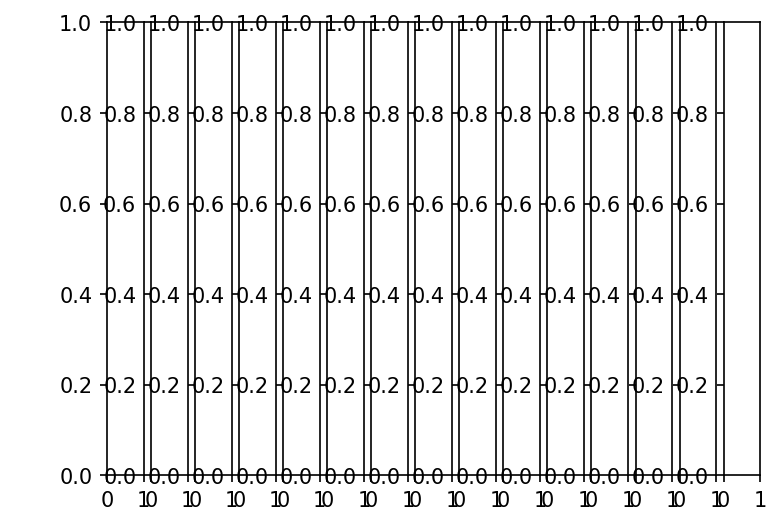

In [14]:
# for i in range(10):
#     print(f"class {i}")
#     print([rotated_invariance_measure[i][j].shape for j in range(20)])
#     print([invariance_measure[i][j].shape for j in range(20)])
    

rotated_layer_invariance_measure=invariance.eval_stratified_invariance(rotated_invariance_measure)
layer_invariance_measure=invariance.eval_stratified_invariance(invariance_measure)


vmin_stratified,vmax_stratified=invariance.outlier_range_both(rotated_layer_invariance_measure,layer_invariance_measure)

invariance.plot([rotated_layer_invariance_measure],rotated_model,dataset.name,classes,
                savefig=True,savefig_suffix="rotated",class_names=["all_stratified"],vmax=vmax_stratified)
invariance.plot([layer_invariance_measure],model,dataset.name,classes,
                savefig=True,savefig_suffix="unrotated",class_names=["all_stratified"],vmax=vmax_stratified)


In [13]:
measures=[layer_invariance_measure]+invariance_measure_all_dataset
rotated_measures=[rotated_layer_invariance_measure]+rotated_invariance_measure_all_dataset
labels=["stratified","all_dataset"]

invariance.plot_collapsing_layers(rotated_measures,measures,rotated_model,model,dataset.name,labels)

class_labels=[str(i) for i in range(num_classes)]
invariance.plot_collapsing_layers(rotated_invariance_measure,invariance_measure,rotated_model
                                  ,model,dataset.name,class_labels)

NameError: name 'layer_invariance_measure' is not defined